In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
import os
from IPython.display import display
import os
import time
t = time.time()

Nous cherchons à prédire la positivité / négativité d'un tweet à l'aide de la **classification bayésienne naïve**.

# 0. Outils

In [2]:
class Modelisation():
    def __init__(self, X, y, vectorizer, model, scaling=True):
        X = vectorizer.fit_transform(X)

        if scaling:
            scaler = StandardScaler(with_mean=False)
            X = scaler.fit_transform(X)
        
        if isinstance(model, GaussianNB):
            X = X.toarray()

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
        sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        probs = model.predict_proba(X_test)[:, 1]

        metrics_score = {'accuracy': sc_accuracy, 'balanced_accuracy': sc_balanced_accuracy, 'roc_auc': sc_roc_auc}

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.model = model
        self.probs = probs
        self.metrics_score = metrics_score
    
    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def show_conf_matrix(self):
        metrics.plot_confusion_matrix(self.model, self.X_test, self.y_test, cmap='Blues')
        plt.show()

        print(f"Accuracy : {self.metrics_score['accuracy']:.4f}")
        print(f"Balanced accuracy : {self.metrics_score['balanced_accuracy']:.4f}")
        print(f"ROC AUC : {self.metrics_score['roc_auc']:.4f}")

In [3]:
def comparaison(X, y, N, model, scaling=True, show_graph=True):
    """
    Compraison des modèles par rapport à la courbe ROC
    N correspond au nombre de features
    """
    table = []
    
    m = Modelisation(X, y, CountVectorizer(max_features = N), model)
    fpr, tpr, _ = metrics.roc_curve(m.y_test, m.probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, label=f"CountVectorizer {N}")
    table.append(m.metrics_score)

    m = Modelisation(X, y, TfidfVectorizer(max_features = N), model)
    fpr, tpr, _ = metrics.roc_curve(m.y_test, m.probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, label=f"TfidfVectorizer {N}")
    table.append(m.metrics_score)

    m = Modelisation(X, y, CountVectorizer(max_features = N, ngram_range=(1,2)), model)
    fpr, tpr, _ = metrics.roc_curve(m.y_test, m.probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, label=f"CountVectorizer {N} ngram 2")
    table.append(m.metrics_score)

    m = Modelisation(X, y, TfidfVectorizer(max_features = N, ngram_range=(1,2)), model)
    fpr, tpr, _ = metrics.roc_curve(m.y_test, m.probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, label=f"TfidfVectorizer {N} ngram 2")
    table.append(m.metrics_score)
    
    if show_graph:
        plt.plot([0, 1], [0, 1], "r-")
        plt.plot([0, 0, 1], [0, 1, 1], 'b-')
        plt.legend()
        plt.show()
    
    df = pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N} ngram 2", f"TfidfVectorizer {N} ngram 2"])
    
    return df

In [4]:
def influence_preprocessing(N, model, show_graph=False, show_table=False):
    tables = []
    for stop_words in [False, True]:
        for lemmatization in [False, True]:
            for negation in [False, True]:
                file = "train"
                if stop_words:
                    file += "_stop"
                if lemmatization:
                    file += "_lemm"
                if  negation:
                    file += "_neg"
                print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
                df_temp = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2")).sample(NB_DATA, random_state=1234)
                X = df_temp.text.to_list()
                y = df_temp.sentiment.to_list()            
                df_metrics = comparaison(X, y, N, model, show_graph=show_graph)
                if show_table:
                    display(df_metrics)
                df_metrics['stop_words'] = stop_words
                df_metrics['lemmatization'] = lemmatization
                df_metrics['negation'] = negation
                tables.append(df_metrics)
    return pd.concat(tables)

In [5]:
def influence_features(X, y, max_features_list, model, scaling=True):
    table = []
    for max_features in max_features_list:
        m = Modelisation(X, y, CountVectorizer(max_features=max_features), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer"
        table.append(metrics_score)

        m = Modelisation(X, y, TfidfVectorizer(max_features=max_features), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer"
        table.append(metrics_score)

        m = Modelisation(X, y, CountVectorizer(max_features=max_features, ngram_range=(1,2)), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer ngram 2"
        table.append(metrics_score)

        m = Modelisation(X, y, TfidfVectorizer(max_features=max_features, ngram_range=(1,2)), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer ngram 2"
        table.append(metrics_score)

    df = pd.DataFrame(table)

    methods = list(set(df.method))
    scores = list(df.columns[:-2])
    fig, axes = plt.subplots(1, len(scores), figsize=(20, 6))
    for i_score in range(len(scores)):
        for j_method in range(len(methods)):
            df[df.method == methods[j_method]].plot(x='features', y=scores[i_score], label=methods[j_method], ax=axes[i_score])
        axes[i_score].set(xlabel='Nombre de features')
        axes[i_score].legend()
        axes[i_score].set_title(scores[i_score])
    plt.show()
    return df

# 1. Chargement d'une base Sentiment140 préprocessée 

In [6]:
NB_DATA = 100000
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if NEGATION:
    file += "_neg"
df = pd.read_pickle(os.path.join("data", "sentiment140", file + ".bz2")).sample(NB_DATA, random_state=1234)

In [7]:
df.head(10)

,sentiment,id,date,query_string,user,text
599410,Negative,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
549856,Negative,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
1363048,Positive,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
558776,Negative,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
1582398,Positive,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
1353343,Positive,2046706853,Fri Jun 05 12:34:26 PDT 2009,NO_QUERY,WahooPooh,as tempting as that is i am just waiting on my...
586354,Negative,2215937155,Wed Jun 17 18:49:10 PDT 2009,NO_QUERY,amandarie,cool how i have to be stuck at home i want to ...
860355,Positive,1676343245,Fri May 01 21:46:07 PDT 2009,NO_QUERY,MatchesMalone,oh and followfriday my writing partner because...
521668,Negative,2192486836,Tue Jun 16 07:06:35 PDT 2009,NO_QUERY,hockeyfan45214,you would think if i continue to block someone...
243888,Negative,1981647618,Sun May 31 09:35:54 PDT 2009,NO_QUERY,ilovemytroops,nevaeh buchanan missing friends of her mother ...


In [8]:
X = df.text.to_list()
y = df.sentiment.to_list()

# 2. Gaussian Naive Bayes

## 2.1 Comparaison entre CountVectorizer et TfidfVectorizer

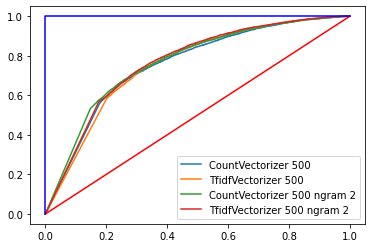

Wall time: 19.7 s


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 500,0.69125,0.699269,0.756736
TfidfVectorizer 500,0.70365,0.705249,0.755654
CountVectorizer 500 ngram 2,0.70110,0.704653,0.768165
TfidfVectorizer 500 ngram 2,0.71075,0.710815,0.766956


In [9]:
%%time
comparaison(X, y, 500, GaussianNB())

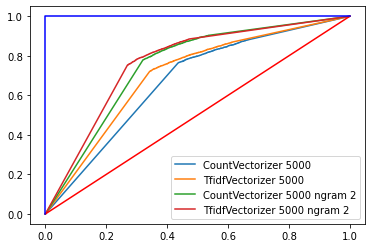

Wall time: 1min 37s


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 5000,0.66075,0.669049,0.670408
TfidfVectorizer 5000,0.68800,0.689589,0.701881
CountVectorizer 5000 ngram 2,0.72825,0.731327,0.749425
TfidfVectorizer 5000 ngram 2,0.74120,0.741487,0.766212


In [10]:
%%time
comparaison(X, y, 5000, GaussianNB())

A priori le TfidfVectorizer 500 semble le plus approprié.

## 2.2 Comparaison des méthodes de pré-processing

In [11]:
%%time
df_metrics = influence_preprocessing(500, GaussianNB())

stop_words: False, lemmatization: False, negation: False
stop_words: False, lemmatization: False, negation: True
stop_words: False, lemmatization: True, negation: False
stop_words: False, lemmatization: True, negation: True
stop_words: True, lemmatization: False, negation: False
stop_words: True, lemmatization: False, negation: True
stop_words: True, lemmatization: True, negation: False
stop_words: True, lemmatization: True, negation: True
Wall time: 3min 31s


In [12]:
df_metrics.sort_values(by="roc_auc", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
TfidfVectorizer 500 ngram 2,0.71530,0.715305,0.771489,False,True,False
CountVectorizer 500 ngram 2,0.70725,0.709766,0.770466,False,True,False
CountVectorizer 500 ngram 2,0.70110,0.704653,0.768165,False,False,False
CountVectorizer 500 ngram 2,0.70215,0.706521,0.767446,False,True,True
TfidfVectorizer 500 ngram 2,0.71075,0.710815,0.766956,False,False,False
TfidfVectorizer 500 ngram 2,0.71105,0.711581,0.766681,False,True,True
CountVectorizer 500,0.69900,0.706051,0.765082,False,True,True
CountVectorizer 500 ngram 2,0.69540,0.699806,0.762888,False,False,True
TfidfVectorizer 500,0.70780,0.709840,0.762250,False,True,True
TfidfVectorizer 500 ngram 2,0.70485,0.705140,0.762156,False,False,True


In [13]:
df_metrics.sort_values(by="balanced_accuracy", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
TfidfVectorizer 500 ngram 2,0.71530,0.715305,0.771489,False,True,False
CountVectorizer 500 ngram 2,0.70465,0.711610,0.760463,True,True,True
TfidfVectorizer 500 ngram 2,0.71105,0.711581,0.766681,False,True,True
TfidfVectorizer 500 ngram 2,0.71075,0.710815,0.766956,False,False,False
TfidfVectorizer 500,0.70780,0.709840,0.762250,False,True,True
CountVectorizer 500 ngram 2,0.70725,0.709766,0.770466,False,True,False
TfidfVectorizer 500,0.70615,0.709386,0.760543,False,False,True
CountVectorizer 500 ngram 2,0.70010,0.707895,0.755525,True,True,False
TfidfVectorizer 500 ngram 2,0.70480,0.707817,0.754647,True,True,False
CountVectorizer 500,0.70090,0.707507,0.757425,True,True,True


La combinaison optimale semble correspondre à `stop_words=False, lemmatization=False, negation=False` pour ce nombre de features.

## 2.3 Comparaison par rapport au nombre de features

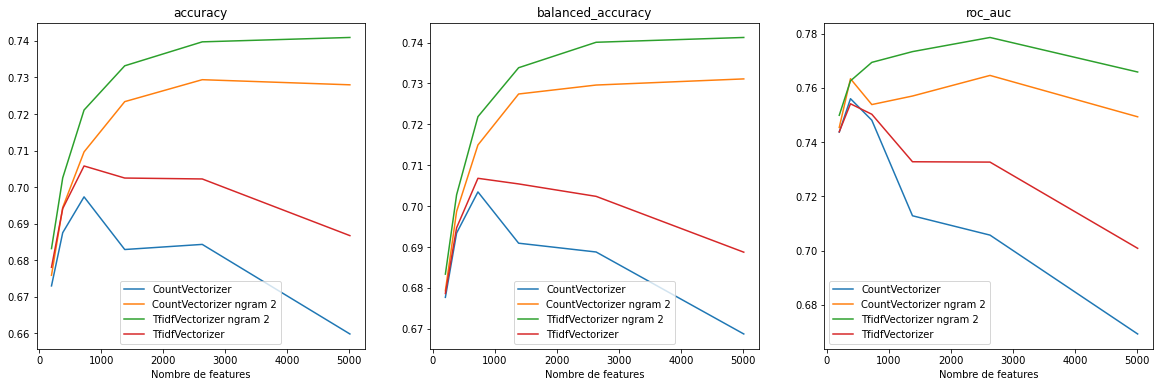

Wall time: 3min 48s


In [14]:
%%time
max_features_list = np.logspace(2.3, 3.7, 6, endpoint=True, dtype=int)
_ = influence_features(X, y, max_features_list, GaussianNB())

# 3. Multinomial NB

## 3.1 Comparaison entre CountVectorizer et TfidfVectorizer

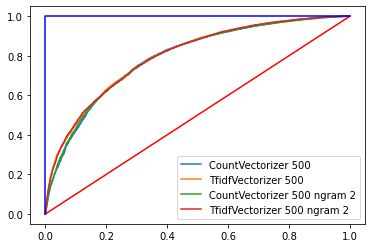

Wall time: 13.9 s


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 500,0.72280,0.722881,0.791750
TfidfVectorizer 500,0.72280,0.722901,0.798565
CountVectorizer 500 ngram 2,0.72180,0.721814,0.791805
TfidfVectorizer 500 ngram 2,0.71965,0.719675,0.797992


In [15]:
%%time
comparaison(X, y, 500, MultinomialNB(alpha=1)) #par défaut alpha=1 : Laplace smoothing parameter

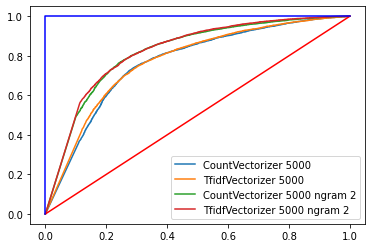

Wall time: 13.4 s


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 5000,0.72340,0.723435,0.766215
TfidfVectorizer 5000,0.72070,0.720702,0.771534
CountVectorizer 5000 ngram 2,0.76060,0.760601,0.819857
TfidfVectorizer 5000 ngram 2,0.75845,0.758453,0.824121


In [16]:
%%time
comparaison(X, y, 5000, MultinomialNB(alpha=1)) #par défaut alpha=1 : Laplace smoothing parameter

A priori le TfIdfVectorizer (sans ngram) semble le plus approprié.

## 3.2 Comparaison des méthodes de pré-processing

In [17]:
%%time
df_metrics = influence_preprocessing(500, MultinomialNB(alpha=1))

stop_words: False, lemmatization: False, negation: False
stop_words: False, lemmatization: False, negation: True
stop_words: False, lemmatization: True, negation: False
stop_words: False, lemmatization: True, negation: True
stop_words: True, lemmatization: False, negation: False
stop_words: True, lemmatization: False, negation: True
stop_words: True, lemmatization: True, negation: False
stop_words: True, lemmatization: True, negation: True
Wall time: 2min 43s


In [18]:
df_metrics.sort_values(by="roc_auc", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
TfidfVectorizer 500 ngram 2,0.72705,0.727059,0.803151,False,True,False
TfidfVectorizer 500,0.72495,0.725205,0.802768,False,True,True
TfidfVectorizer 500,0.72240,0.722755,0.798747,False,False,True
TfidfVectorizer 500,0.72280,0.722901,0.798565,False,False,False
TfidfVectorizer 500 ngram 2,0.71965,0.719675,0.797992,False,False,False
TfidfVectorizer 500,0.72075,0.720766,0.797682,False,True,False
TfidfVectorizer 500 ngram 2,0.72220,0.722236,0.797219,False,True,True
CountVectorizer 500,0.72635,0.726533,0.797031,False,True,True
CountVectorizer 500 ngram 2,0.72720,0.727232,0.795446,False,True,False
TfidfVectorizer 500 ngram 2,0.71450,0.716001,0.792781,True,True,True


In [19]:
df_metrics.sort_values(by="balanced_accuracy", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
CountVectorizer 500 ngram 2,0.72720,0.727232,0.795446,False,True,False
TfidfVectorizer 500 ngram 2,0.72705,0.727059,0.803151,False,True,False
CountVectorizer 500,0.72635,0.726533,0.797031,False,True,True
TfidfVectorizer 500,0.72495,0.725205,0.802768,False,True,True
CountVectorizer 500,0.72310,0.723099,0.791715,False,True,False
TfidfVectorizer 500,0.72280,0.722901,0.798565,False,False,False
CountVectorizer 500,0.72280,0.722881,0.791750,False,False,False
CountVectorizer 500,0.72255,0.722817,0.792202,False,False,True
TfidfVectorizer 500,0.72240,0.722755,0.798747,False,False,True
TfidfVectorizer 500 ngram 2,0.72220,0.722236,0.797219,False,True,True


La combinaison optimale semble correspondre à `stop_words=False, lemmatization=False, negation=False` pour ce nombre de features.

## 3.3 Comparaison par rapport au nombre de features

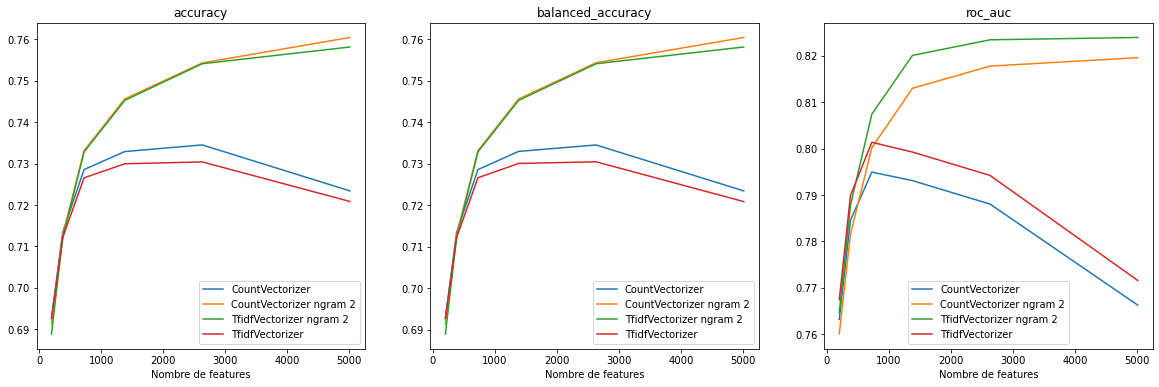

Wall time: 1min 20s


In [20]:
%%time
_ = influence_features(X, y, max_features_list, MultinomialNB(alpha=1))

## 3.4. Grid Search

In [22]:
%%time
#CountVectorizer
text_clf = Pipeline([('vect', CountVectorizer()), ('clf', MultinomialNB())])
nb_max_words = len(CountVectorizer().fit(X).get_feature_names())

parameters = {'vect__max_features' : np.logspace(2.3, np.log10(nb_max_words), 6, endpoint=True, dtype=int),
          'clf__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1]
}

grid_clf = GridSearchCV(text_clf, parameters, scoring = 'balanced_accuracy', cv=5)
_ = grid_clf.fit(X, y)


print('Balanced Accuracy : %.3f'%grid_clf.best_estimator_.score(X, y))
print('Best Balanced Accuracy Through Grid Search : %.3f'%grid_clf.best_score_)
print('Best Parameters : ',grid_clf.best_params_)

Balanced Accuracy : 0.787
Best Balanced Accuracy Through Grid Search : 0.768
Best Parameters :  {'clf__alpha': 1, 'vect__max_features': 5574}
Wall time: 7min 34s


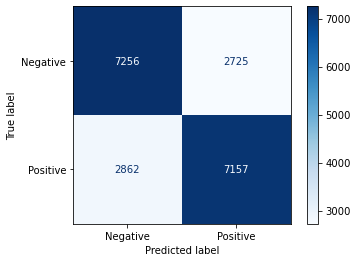

Accuracy : 0.7207
Balanced accuracy : 0.7207
ROC AUC : 0.7611
Wall time: 1.8 s


In [23]:
%%time
m = Modelisation(X, y, CountVectorizer(max_features=5574), MultinomialNB(alpha=1))
m.show_conf_matrix()

In [24]:
%%time
#Tfidfvectorizer
text_clf = Pipeline([('idf', TfidfVectorizer()), ('clf', MultinomialNB())])
nb_max_words = len(TfidfVectorizer().fit(X).get_feature_names())

parameters = {'idf__max_features' : np.logspace(2.3, np.log10(nb_max_words), 6, endpoint=True, dtype=int),
          'clf__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1]
}

grid_clf = GridSearchCV(text_clf, parameters, scoring = 'balanced_accuracy', cv=5)
_ = grid_clf.fit(X, y)

print('Balanced Accuracy : %.3f'%grid_clf.best_estimator_.score(X, y))
print('Best Balanced Accuracy Through Grid Search : %.3f'%grid_clf.best_score_)
print('Best Parameters : ',grid_clf.best_params_)

Balanced Accuracy : 0.785
Best Balanced Accuracy Through Grid Search : 0.761
Best Parameters :  {'clf__alpha': 1, 'idf__max_features': 5574}
Wall time: 7min 33s


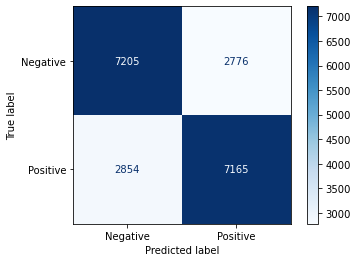

Accuracy : 0.7185
Balanced accuracy : 0.7185
ROC AUC : 0.7664
Wall time: 1.78 s


In [25]:
%%time
m = Modelisation(X, y, TfidfVectorizer(max_features=5574), MultinomialNB(alpha=1))
m.show_conf_matrix()

In [26]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:52:29
